## Regression Analysis for Total Recovery Costs of Medical Patients

This is part of a Health insurance company. It is important to be able to set premiums on insurance is the ability to accurately predict the patient costs. Based on `hospital.csv` data, primary goal, to create a regression model that can predict the total cost of a patient stay given a set of patient featrues. 

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [50]:
data = pd.read_csv('hospital.csv')

In [51]:
data.head()

Health Service Area Hospital County  Operating Certificate Number  \
0          Western NY            Erie                     1427000.0   
1          Western NY         Genesee                     1801000.0   
2          Western NY         Genesee                     1801000.0   
3          Western NY         Genesee                     1801000.0   
4          Western NY         Genesee                     1801000.0   

   Facility Id                                      Facility Name  \
0        280.0                          Bertrand Chaffee Hospital   
1        339.0  United Memorial Medical Center North Street Ca...   
2        339.0  United Memorial Medical Center North Street Ca...   
3        339.0  United Memorial Medical Center North Street Ca...   
4        339.0  United Memorial Medical Center North Street Ca...   

     Age Group Zip Code - 3 digits Gender        Race          Ethnicity  ...  \
0     18 to 29                 140      F       White  Not Span/Hispanic  ...   
1     18 to 29                 140      F       White  Not Span/Hispanic  ...   
2     50 to 69                 140      M  Other Race   Spanish/Hispanic  ...   
3     30 to 49                 140      F  Other Race  Not Span/Hispanic  ...   
4  70 or Older                 144      F       White  Not Span/Hispanic  ...   

   APR Severity of Illness Description APR Risk of Mortality  \
0                             Moderate                 Minor   
1                                Minor                 Minor   
2                                Minor                 Minor   
3                                Major                 Major   
4                             Moderate              Moderate   

  APR Medical Surgical Description        Payment Typology 1  \
0                          Medical  Private Health Insurance   
1                         Surgical    Blue Cross/Blue Shield   
2                          Medical                  Self-Pay   
3                          Medical                  Medicaid   
4                          Medical                  Medicare   

  Attending Provider License Number  Other Provider License Number  \
0                          163390.0                       166116.0   
1                          216110.0                       216110.0   
2                          215786.0                     90016551.0   
3                          265859.0                     90335640.0   
4                          265859.0                     90335640.0   

  Birth Weight  Emergency Department Indicator Total Charges  Total Costs  
0            0                               Y      $7108.00     $3913.96  
1            0                               N     $18143.55     $5776.46  
2            0                               Y      $5536.92     $1855.02  
3            0                               Y      $8135.23     $3242.32  
4            0                               Y      $4016.86     $1117.80  

[5 rows x 32 columns]

In [52]:
data.columns

Index(['Health Service Area', 'Hospital County',
       'Operating Certificate Number', 'Facility Id', 'Facility Name',
       'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Length of Stay', 'Type of Admission', 'Patient Disposition',
       'CCS Diagnosis Code', 'CCS Diagnosis Description', 'CCS Procedure Code',
       'CCS Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Attending Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Emergency Department Indicator', 'Total Charges',
       'Total Costs'],
      dtype='object')

Lets calculate the mean Total Charges per County. Also calculate the median "Length of Stay" per severity level of illness (based on "APR Severity of Illness Description" column). This will give us a baseline understanding of costs to build an intuition of the effectiveness of a forecasting model. First, convert string to numeric.

In [53]:
data['Total Charges'] = data['Total Charges'].apply(lambda s: float(s[1:]))

Compute mean per county 

In [54]:
data.groupby('Hospital County')['Total Charges'].mean()

Hospital County
Albany         23872.323333
Allegany       15685.273171
Bronx          16729.619436
Cattaraugus    17925.985874
Cayuga         21816.919188
Chautauqua     14918.541611
Delaware       11572.747259
Dutchess       32594.014291
Erie           26378.176973
Fulton         20143.994545
Genesee        13481.466509
Herkimer        8564.491111
Jefferson      12766.380000
Lewis          17473.441316
Madison        32997.203675
Manhattan      27820.246300
Monroe          7438.823333
Montgomery     17716.981537
Nassau         38065.795276
Niagara        15015.041394
Oneida         21269.245675
Ontario        23578.556000
Orange         29825.350306
Otsego          9309.435166
Putnam         46904.927981
Rensselaer     33121.299556
Rockland       25887.473768
Schenectady    38387.597963
St Lawrence    14776.893000
Steuben         8805.128449
Suffolk        57179.206284
Ulster         24355.143657
Westchester    44941.125364
Wyoming         9682.312098
Yates          10969.203077
Name

In [55]:
data['Length of Stay'] = data['Length of Stay'].apply(lambda l: float(l))

In [56]:
data['Length of Stay'].head()

0    5.0
1    3.0
2    1.0
3    2.0
4    1.0
Name: Length of Stay, dtype: float64

Lets examine the APR severity based on Length of stay. 

In [57]:
data.groupby('APR Severity of Illness Description')['Length of Stay'].median()

APR Severity of Illness Description
Extreme     8.0
Major       5.0
Minor       2.0
Moderate    3.0
Name: Length of Stay, dtype: float64

Now, we see the Pearson Correlation Coefficient valeus for the numeric fetures, and `Total Charges`. 

In [58]:
corr_coeff = data.corrwith(data['Total Charges'])
# dropping the total charges as it will have corr 1
feat_corr = corr_coeff.drop('Total Charges')

/tmp/ipykernel_1181759/3954260328.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_coeff = data.corrwith(data['Total Charges'])


<AxesSubplot: >

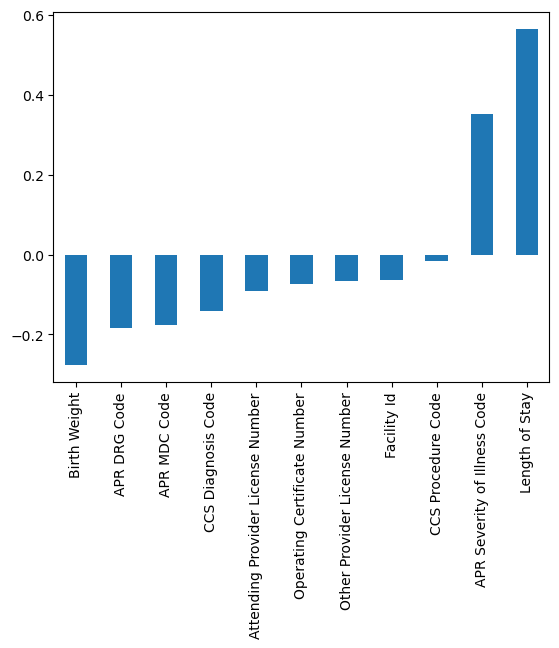

In [59]:
feat_corr.sort_values().plot(kind='bar')

As we can see, Lenght of stay and APR Severity of illness have positive correlation with Total Charges. Lets, expolre them more. 

Text(0, 0.5, 'Frequency')

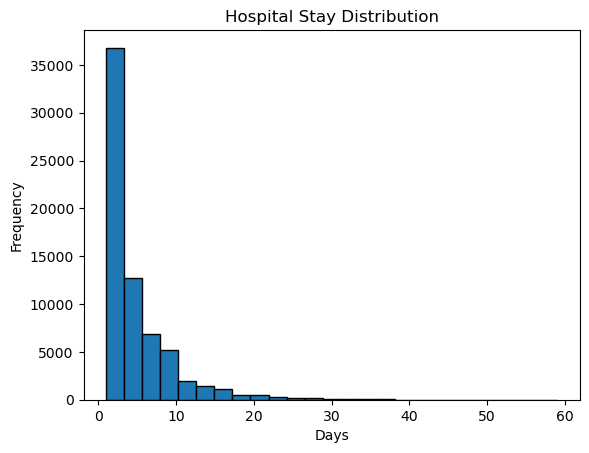

In [60]:
plt.figure()
plt.hist(data['Length of Stay'], bins=25, edgecolor='black');
plt.title("Hospital Stay Distribution")
plt.xlabel("Days")
plt.ylabel("Frequency")

From figure, Most of the patients have 9-10 days of hospital stay.

Text(0, 0.5, 'Frequency')

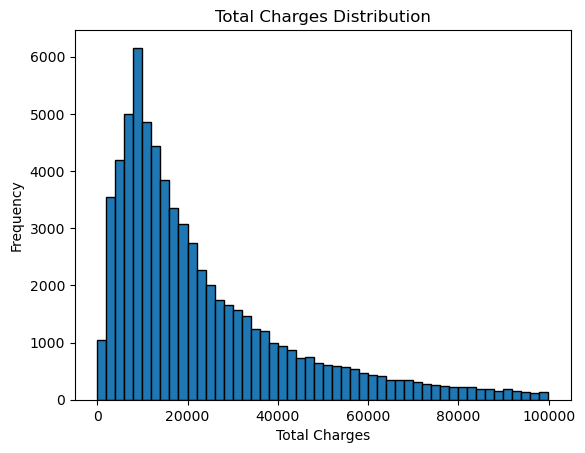

In [61]:
plt.figure()
plt.hist(data['Total Charges'], bins=50, edgecolor='black');
plt.title("Total Charges Distribution")
plt.xlabel("Total Charges")
plt.ylabel("Frequency")

Most of the patients have 8000 - 10000 totals charges incurred, during their each visit or stay.


### Distribution of Charges for most common hopitalizations

In [62]:
# top 10 common diagnosis values
diagnosis = data["CCS Diagnosis Description"].value_counts()

In [63]:
top_10

Liveborn                                                             6363
Septicemia (except in labor)                                         3200
Osteoarthritis                                                       2906
Congestive heart failure; nonhypertensive                            1929
Alcohol-related disorders                                            1686
                                                                     ... 
Disorders of lipid metabolism                                           1
Administrative/social admission                                         1
Disorders usually diagnosed in infancy, childhood, or adolescence       1
Cancer of other male genital organs                                     1
Immunizations and screening for infectious disease                      1
Name: CCS Diagnosis Description, Length: 254, dtype: int64

In [64]:
top_10_dia = diagnosis[:10].index
top_10_dia

Index(['Liveborn', 'Septicemia (except in labor)', 'Osteoarthritis',
       'Congestive heart failure; nonhypertensive',
       'Alcohol-related disorders',
       'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
       'Chronic obstructive pulmonary disease and bronchiectasis',
       'Cardiac dysrhythmias', 'Substance-related disorders',
       'Previous C-section'],
      dtype='object')

Get the corresponding entries nad charges for top 10.

In [65]:
corresponding_entries = data[data["CCS Diagnosis Description"].isin(top_10_dia)]["CCS Diagnosis Description"]
corresponding_charges = data[data["CCS Diagnosis Description"].isin(top_10_dia)]["Total Charges"]

In [66]:
corresponding_charges.max(), corresponding_charges.min()

(99923.72, 1.0)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Previous C-section'),
  Text(1, 0, 'Cardiac dysrhythmias'),
  Text(2, 0, 'Septicemia (except in labor)'),
  Text(3, 0, 'Chronic obstructive pulmonary disease and bronchiectasis'),
  Text(4, 0, 'Osteoarthritis'),
  Text(5, 0, 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)'),
  Text(6, 0, 'Liveborn'),
  Text(7, 0, 'Congestive heart failure; nonhypertensive'),
  Text(8, 0, 'Alcohol-related disorders'),
  Text(9, 0, 'Substance-related disorders')])

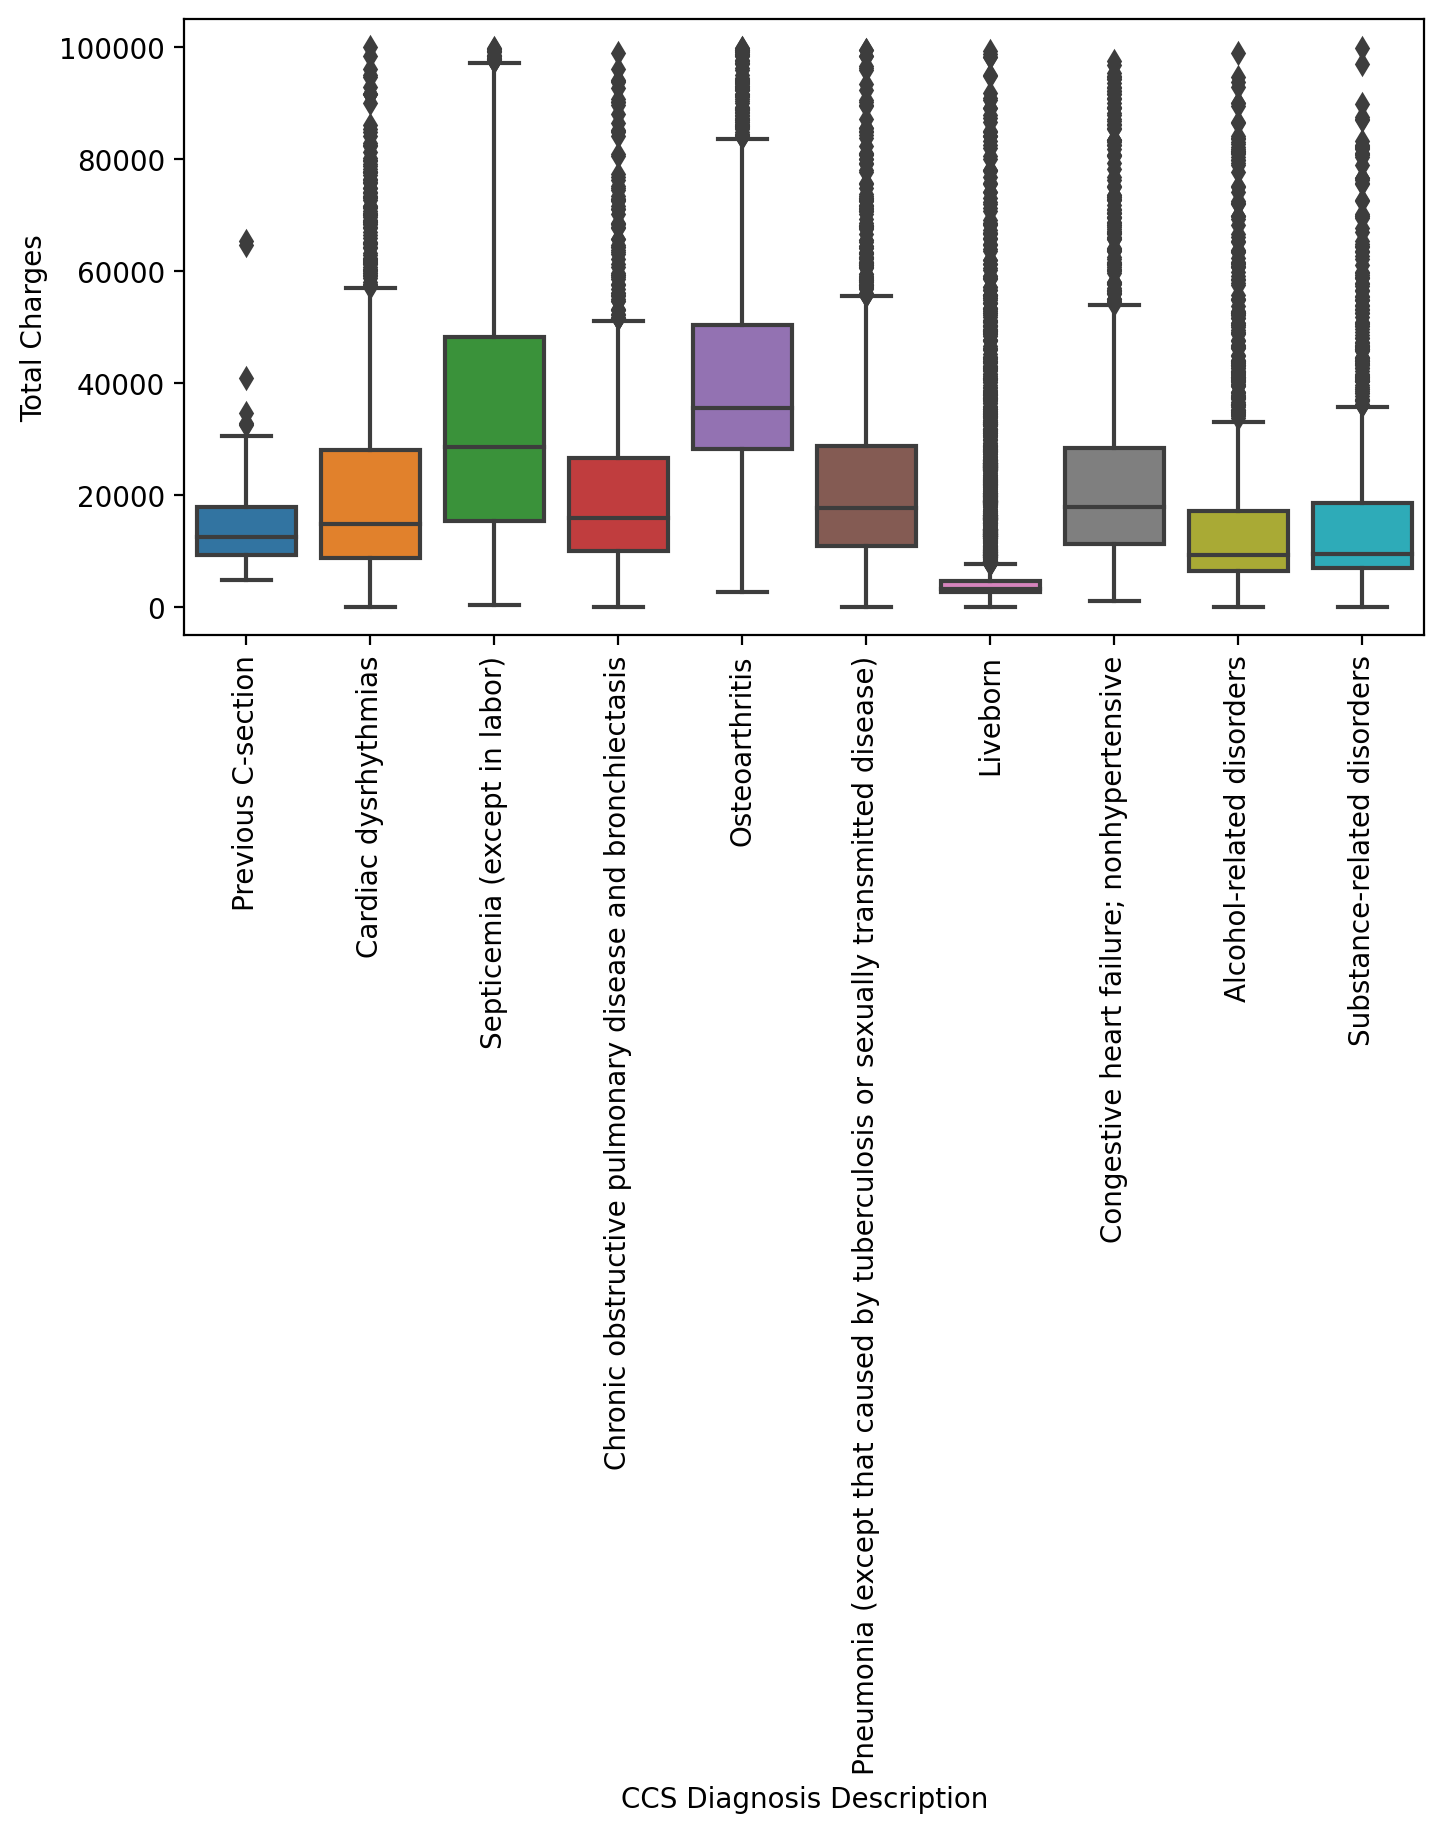

In [67]:
plt.figure(figsize=(8,4), dpi=200)
sns.boxplot(x=corresponding_entries, y=corresponding_charges)
plt.xticks(rotation=90)

Encoding categorical features. For more techniques - [Gitlab repo](https://gitlab.com/pvsnp9/Feature-Enginering/-/tree/main/section_categorical_var_encoding)

In [69]:
encoder = LabelEncoder()

In [71]:
# extract categorical feature 
categorical_features = data.select_dtypes(include=['object']).columns
categorical_features

Index(['Health Service Area', 'Hospital County', 'Facility Name', 'Age Group',
       'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Type of Admission', 'Patient Disposition', 'CCS Diagnosis Description',
       'CCS Procedure Description', 'APR DRG Description',
       'APR MDC Description', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'APR Medical Surgical Description',
       'Payment Typology 1', 'Emergency Department Indicator', 'Total Costs'],
      dtype='object')

In [72]:
data_encoded = data.copy()
data_encoded[categorical_features] = data_encoded[categorical_features].apply(encoder.fit_transform)

In [73]:
data_encoded

Health Service Area  Hospital County  Operating Certificate Number  \
0                        6                8                     1427000.0   
1                        6               10                     1801000.0   
2                        6               10                     1801000.0   
3                        6               10                     1801000.0   
4                        6               10                     1801000.0   
...                    ...              ...                           ...   
67923                    4               30                     5149000.0   
67924                    4               30                     5149000.0   
67925                    4               30                     5149000.0   
67926                    4               30                     5149000.0   
67927                    4               30                     5149000.0   

       Facility Id  Facility Name  Age Group  Zip Code - 3 digits  Gender  \
0            280.0              3          1                   39       0   
1            339.0             53          1                   39       0   
2            339.0             53          3                   39       1   
3            339.0             53          2                   39       0   
4            339.0             53          4                   43       0   
...            ...            ...        ...                  ...     ...   
67923        895.0             20          4                   16       1   
67924        895.0             20          4                   16       0   
67925        895.0             20          1                   16       0   
67926        895.0             20          2                   16       0   
67927        895.0             20          2                   16       0   

       Race  Ethnicity  ...  APR Severity of Illness Description  \
0         3          1  ...                                    3   
1         3          1  ...                                    2   
2         2          2  ...                                    2   
3         2          1  ...                                    1   
4         3          1  ...                                    3   
...     ...        ...  ...                                  ...   
67923     3          1  ...                                    1   
67924     3          1  ...                                    1   
67925     3          1  ...                                    3   
67926     3          1  ...                                    3   
67927     3          1  ...                                    3   

       APR Risk of Mortality  APR Medical Surgical Description  \
0                          2                                 0   
1                          2                                 1   
2                          2                                 0   
3                          1                                 0   
4                          3                                 0   
...                      ...                               ...   
67923                      3                                 1   
67924                      3                                 0   
67925                      2                                 0   
67926                      2                                 0   
67927                      2                                 1   

       Payment Typology 1  Attending Provider License Number  \
0                       7                           163390.0   
1                       0                           216110.0   
2                       8                           215786.0   
3                       4                           265859.0   
4                       5                           265859.0   
...                   ...                                ...   
67923                   5                           210655.0   
67924                   5          

### Model Dev and Test 

Create a train-test split on dataset for Machine Learning model. Lets use 80:20.

In [75]:
X,y  = data_encoded.drop(['Total Charges', 'Total Costs'], axis=1), data_encoded['Total Charges']

In [77]:
X.shape, y.shape

((67928, 30), (67928,))

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [79]:
X_train.shape, X_test.shape

((54342, 30), (13586, 30))

### Create and Evaluate Random Forest Regression Model 

In [81]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [82]:
preds = random_forest.predict(X_test)

In [86]:
mean_absolute_error(preds, y_test)

3798.8126189974478